# Package

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import cv2

print('tf version: ', tf.__version__)

tf version:  2.10.0


# visualize a sample image

In [2]:
# show sample image
img = cv2.imread('./running_dog.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

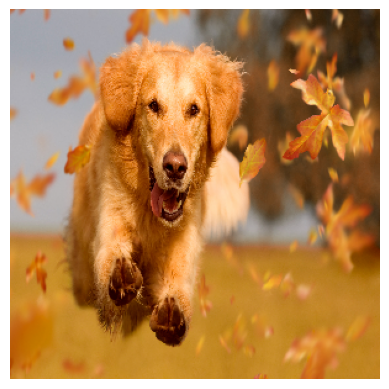

In [3]:
plt.imshow(img)
plt.axis('off')
plt.show()

## Build the model

For the classifier, we will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) available in [Tensorflow Hub](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4). This has pre-trained weights that is able to detect 1001 classes. For [details](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4).

In [4]:
module_handle = 'https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'

In [5]:
model = tf.keras.models.Sequential([
    hub.KerasLayer(module_handle),
    tf.keras.layers.Activation('softmax')
])

model.build([None, 300, 300, 3]) 

Metal device set to: Apple M2


2022-10-16 15:48:09.068524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-16 15:48:09.068749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Compute Gradients

get the gradients of the loss with respect to the input image pixels. This is the key step to generate the map later.

In [6]:
# golden retriever's class ID in ImageNet
class_index = 208   

# number of classes in the model's training data
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

2022-10-16 15:48:47.120457: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-16 15:48:47.132744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-16 15:48:48.001678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Visualize the results


In [7]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

In [9]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

# coordinates of the first pixel where the max and min values are located
max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

print(normalized_tensor[max_pixel])
print(normalized_tensor[min_pixel])

0.12294318
0.0

(79, 90)
(0, 299)

tf.Tensor(254, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)


Let's superimpose the normalized tensor to the input image to get more context. You can see that the strong pixels are over the object and that is a good indication that the model is looking at the correct part of the image.

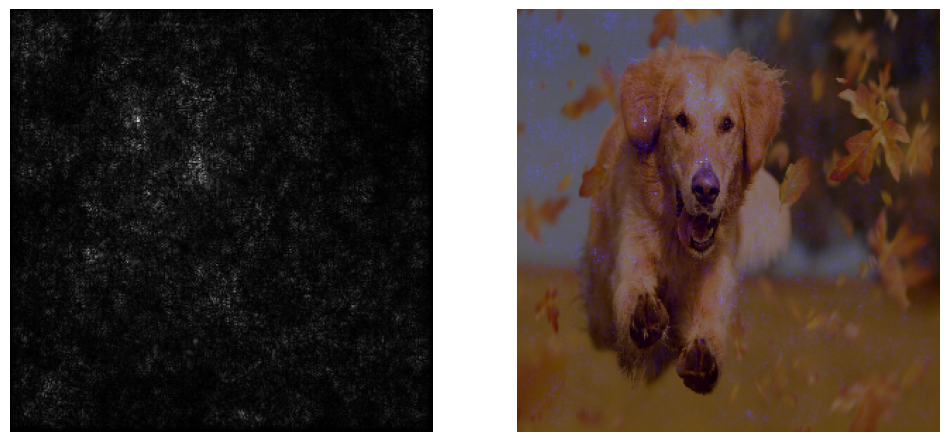

In [10]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
ax = fig.add_subplot(1, 2, 2)
plt.imshow(super_imposed)
plt.axis('off')
plt.show()